# Just Some old codes -- for considration

In [ ]:
import numpy as np
arr = np.random.randn(5,3)

arr.sort(1)
arr.sort(0)



from enum import Enum
class Country(Enum):
    Afghanistan = 93
    Albania = 355
    Algeria = 213
    Andorra = 376
    Angola = 244
    Antarctica = 672
for data in Country:
    print('{:15} = {}'.format(data.name, data.value))

# Load data

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re 
import datetime

from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [2]:
df = pd.read_csv('data.csv', encoding='latin-1')

In [3]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


**Re-store data**

In [4]:
newdata = df        # (541909, 8)

**Pre-define functions**

In [5]:
# change data type:
def chagfmt(dataname, col1, format, *arg):
  dataname[col1] = dataname[col1].astype(format)

In [6]:
# merge two lists:
def merge(list1, list2): 
      
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))] 
    return merged_list 

# Data Cleaning -- missing values

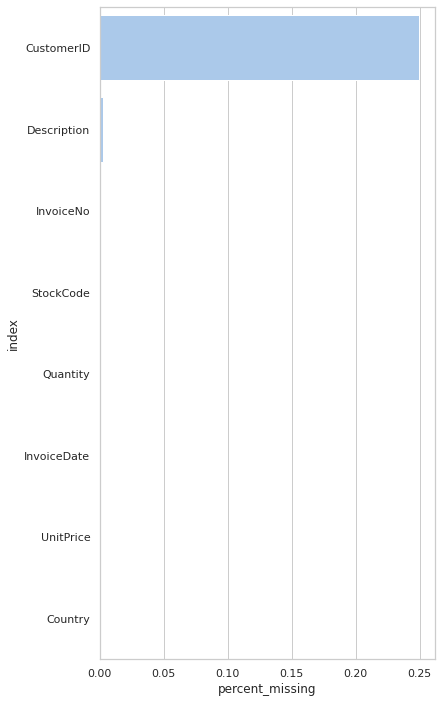

In [7]:
def chk_ms_val(data):
  # prepare for plot the missing value
  percent_missing = data.isnull().sum() / len(data)
  percent_missing_df = pd.DataFrame({'percent_missing': percent_missing})
  percent_missing_df = percent_missing_df.sort_values(['percent_missing'], ascending = False).reset_index(drop=False)

  # define the style of the plot
  sns.set(style="whitegrid")
  
  # Initialize the matplotlib figure
  f, ax = plt.subplots(figsize=(6, 12))
  # Plot the total crashes
  sns.set_color_codes("pastel")
  sns.barplot(x="percent_missing", y="index", data=percent_missing_df,
              label="Total missing", color="b")
    
chk_ms_val(newdata)

# Data Cleaning -- convert to the right data type

In [8]:
newdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [9]:
colnames = ['InvoiceNo', 'StockCode', 'Description', 'Country']
datatypes = ['str', 'str', 'str', 'category']
tuples = merge(colnames, datatypes)                           # define the 'merge' function

for i, j in tuples:
  chagfmt(newdata, i, j)

# Data cleaning -- InvoiceNo with a "C"

Accoding to chagfmt result above, error happens when convert InvoiceNo into Integer. Let's take a look how many observations mistakely input 'Invoice' as 'StockCode'.

In [10]:
# Check the column 'InvoiceNo' with letters in it.
temp = []

for i in newdata['InvoiceNo']:
  temp.append(any(c.isalpha() for c in i))

In [11]:
InvoiceNo_withC = newdata[temp]                # shape: (541909, 8)
InvoiceNo_withC

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


Ok, so, I think it is obvious that InvoiceNo with form 'C + No' is the refund of 'No' transactions because the 'Quantity' is negative.

In [12]:
# let's find out which are those transactions
temp1 = []

for i in InvoiceNo_withC['InvoiceNo']:
  temp1.append(re.split('(\d+)',i))

In [ ]:
InvoiceNo_refund = []

for i, j in enumerate(temp1):
  InvoiceNo_refund.append(temp1[i][1])

InvoiceNo_refund

In [14]:
all(isinstance(i, str) for i in InvoiceNo_refund)   # check type of elements in a list

True

In [15]:
kkk = list(dict.fromkeys(InvoiceNo_refund))       # get unique elements of a list

In [16]:
newdata[newdata.InvoiceNo.isin(kkk)]              # no observation was selected

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


OK, so, the code above proofed one thing: if you bought one thing then you refund it, a upperletter "C" will be add as prefix to origianl 'InvoiceNo'. 

So, let's take a look at the rate of refund.

In [17]:
# calculate the rate of refund

rate_of_refund = InvoiceNo_withC.shape[0]/newdata.shape[0]
print(f'Conclusion: {rate_of_refund * 100}% of the items get refunded')

Conclusion: 1.7144944999990772% of the items get refunded


# Data Analysis -- NLP to item names

In [20]:
df_nlp = newdata

**Preliminary text exploration -- Fetch word count for each abstract**

In [22]:
df_nlp['word_count'] = df_nlp['Description'].apply(lambda x: len(str(x).split(" ")))

In [25]:
df_nlp[['Description', 'word_count']].head(8)

,Description,word_count
0,WHITE HANGING HEART T-LIGHT HOLDER,5
1,WHITE METAL LANTERN,3
2,CREAM CUPID HEARTS COAT HANGER,5
3,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,RED WOOLLY HOTTIE WHITE HEART.,5
5,SET 7 BABUSHKA NESTING BOXES,5
6,GLASS STAR FROSTED T-LIGHT HOLDER,5
7,HAND WARMER UNION JACK,4


In [30]:
# descriptive statistics of word counts
df_nlp.word_count.describe()

count    541909.000000
mean          4.628665
std           1.205268
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max          10.000000
Name: word_count, dtype: float64

In [32]:
print(f'The average word count is about {int(df_nlp.word_count.describe()[1])} words per abstract. The word count ranges from a minimum of {int(df_nlp.word_count.describe()[3])} to a maximum of {df_nlp.word_count.describe()[7]}.')

The average word count is about 4 words per abstract. The word count ranges from a minimum of 1 to a maximum of 10.0.


**Preliminary text exploration -- Most common and uncommon words**

In [ ]:
#Identify common words
freq = pd.Series(' '.join(df_nlp['Description']).split()).value_counts()[:20]
freq

In [ ]:
#Identify uncommon words
freq1 =  pd.Series(' '.join(df_nlp['Description']).split()).value_counts()[-20:]
freq1                                                                 # There are reasons that this result is not important

**Text Pre-processing**

In [58]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

lem = WordNetLemmatizer()
stem = PorterStemmer()
word = "inversely"
print("stemming:",stem.stem(word))
print("lemmatization:", lem.lemmatize(word, "v"))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
stemming: invers
lemmatization: inversely


In [55]:
# Libraries for text preprocessing
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

In [59]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
new_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]
stop_words = stop_words.union(new_words)

In [60]:
# We will now carry out the pre-processing tasks step-by-step to get a cleaned and normalised text corpus:

corpus = []
for i in range(0, 541909):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', df_nlp['Description'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [ ]:
#View corpus item
corpus

**Data Exploration -- word cloud**

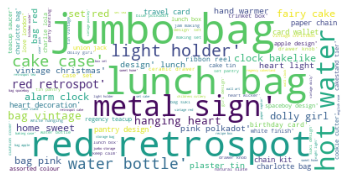

In [64]:
#Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

**Text preparation -- creating a vector of word counts**

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [66]:
list(cv.vocabulary_.keys())[:10]

['white',
 'hanging',
 'heart',
 'light',
 'holder',
 'white hanging',
 'hanging heart',
 'heart light',
 'light holder',
 'white hanging heart']

**Visualize top N uni-grams, bi-grams & tri-grams**

[Text(0, 0, 'set'),
 Text(0, 0, 'bag'),
 Text(0, 0, 'heart'),
 Text(0, 0, 'red'),
 Text(0, 0, 'retrospot'),
 Text(0, 0, 'vintage'),
 Text(0, 0, 'design'),
 Text(0, 0, 'pink'),
 Text(0, 0, 'box'),
 Text(0, 0, 'christmas'),
 Text(0, 0, 'light'),
 Text(0, 0, 'cake'),
 Text(0, 0, 'white'),
 Text(0, 0, 'jumbo'),
 Text(0, 0, 'metal'),
 Text(0, 0, 'blue'),
 Text(0, 0, 'lunch'),
 Text(0, 0, 'card'),
 Text(0, 0, 'sign'),
 Text(0, 0, 'hanging')]

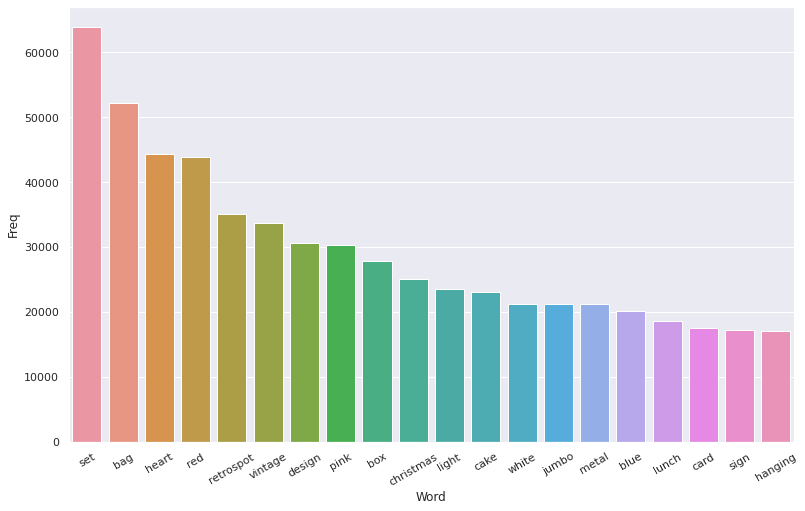

In [68]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

              Bi-gram   Freq
0       red retrospot  19509
1           jumbo bag  17036
2           lunch bag  13793
3          metal sign  12815
4        light holder  11291
5           hot water   9505
6        water bottle   9505
7           cake case   9185
8          dolly girl   6892
9   vintage christmas   6169
10      hanging heart   6034
11      charlotte bag   5882
12      pink polkadot   5731
13        bag vintage   5502
14         fairy cake   5338
15        drawer knob   4953
16          lunch box   4732
17            set red   4638
18      pantry design   4592
19        alarm clock   4551


[Text(0, 0, 'red retrospot'),
 Text(0, 0, 'jumbo bag'),
 Text(0, 0, 'lunch bag'),
 Text(0, 0, 'metal sign'),
 Text(0, 0, 'light holder'),
 Text(0, 0, 'hot water'),
 Text(0, 0, 'water bottle'),
 Text(0, 0, 'cake case'),
 Text(0, 0, 'dolly girl'),
 Text(0, 0, 'vintage christmas'),
 Text(0, 0, 'hanging heart'),
 Text(0, 0, 'charlotte bag'),
 Text(0, 0, 'pink polkadot'),
 Text(0, 0, 'bag vintage'),
 Text(0, 0, 'fairy cake'),
 Text(0, 0, 'drawer knob'),
 Text(0, 0, 'lunch box'),
 Text(0, 0, 'set red'),
 Text(0, 0, 'pantry design'),
 Text(0, 0, 'alarm clock')]

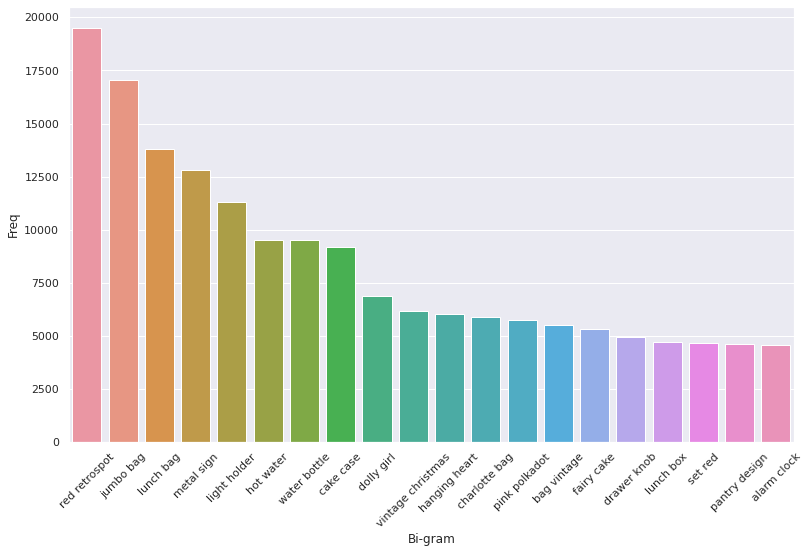

In [69]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

                  Tri-gram  Freq
0         hot water bottle  9505
1     alarm clock bakelike  4461
2          home sweet home  3974
3        bag red retrospot  3797
4       heart light holder  3692
5          paper chain kit  3324
6      hanging heart light  3230
7        bag pink polkadot  3165
8       travel card wallet  3150
9    regency teacup saucer  3052
10     ceramic drawer knob  2496
11           jumbo bag red  2428
12          jam making set  2411
13     white hanging heart  2369
14       set red retrospot  2354
15       tin pantry design  2343
16         bag suki design  2259
17       dolly girl design  2208
18  regency cakestand tier  2200
19          jumbo bag pink  2136


[Text(0, 0, 'hot water bottle'),
 Text(0, 0, 'alarm clock bakelike'),
 Text(0, 0, 'home sweet home'),
 Text(0, 0, 'bag red retrospot'),
 Text(0, 0, 'heart light holder'),
 Text(0, 0, 'paper chain kit'),
 Text(0, 0, 'hanging heart light'),
 Text(0, 0, 'bag pink polkadot'),
 Text(0, 0, 'travel card wallet'),
 Text(0, 0, 'regency teacup saucer'),
 Text(0, 0, 'ceramic drawer knob'),
 Text(0, 0, 'jumbo bag red'),
 Text(0, 0, 'jam making set'),
 Text(0, 0, 'white hanging heart'),
 Text(0, 0, 'set red retrospot'),
 Text(0, 0, 'tin pantry design'),
 Text(0, 0, 'bag suki design'),
 Text(0, 0, 'dolly girl design'),
 Text(0, 0, 'regency cakestand tier'),
 Text(0, 0, 'jumbo bag pink')]

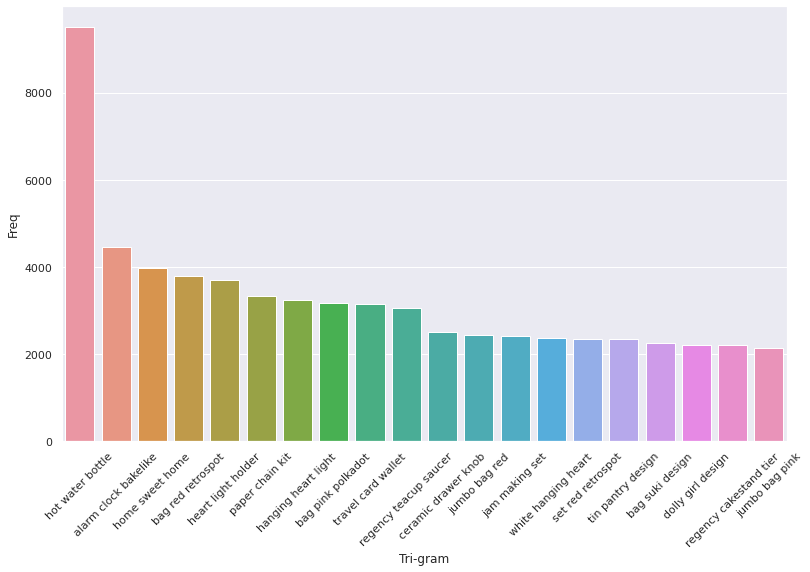

In [70]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

**Converting to a matrix of integers**

In [79]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
doc=corpus[300]
 
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

In [80]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
    
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
babushka light string

Keywords:
light string 0.479
babushka light string 0.479
babushka light 0.479
string 0.404
babushka 0.321


In [81]:
sorted_items

[(4959, 0.4787121372365804),
 (253, 0.4787121372365804),
 (252, 0.4787121372365804),
 (8571, 0.4036715723577381),
 (248, 0.32051206299520546),
 (4926, 0.2163916544877487)]

In [82]:
keywords

{'babushka': 0.321,
 'babushka light': 0.479,
 'babushka light string': 0.479,
 'light string': 0.479,
 'string': 0.404}

# Time serious analysis